In [23]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/caismd_qsar_2024/data


In [25]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle

import re

from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolToSmiles

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from typing import List, Union, Any, Tuple


from lib import utilities, splitters, featurizers, visualization, training, preprocessing, evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, auc, f1_score, roc_curve, precision_recall_curve

In [26]:
seed = 3
utilities.set_seeds(seed=seed)

<div>
<p>
In the following, we will train regression models to predict the percentage of inhibition of the <em>P. falciparum's</em> DD2 growth.
</p>

</div>

<h2>Data Preparation</h2>

Generally, it is recommended to standardize the data, and select feature based on their importance.

However, in our case we will:

1. Skip feature selection: LightGBM models are known for being very efficient at selecting the most important/relevant features. Although delaying feature selection until training might lead to more a computationaly expensive process, we will leave it for now.
    * It is however recommended to perform feature selection when using models that are not as efficient in selecting the correct features (see an example of implementation in the the <em>preprocessing</em> module file).

2. Standardize each fold separately:
    * This method allows the model to learn from the specific distribution of each fold, potentially capturing any fold-specific variations in scale.
    * This is a more robust approach: Each fold's standardization is based only on the training data of that fold, making the model more robust to generalization.
    * However,  standardizing each fold using its own statistics (mean and standard deviation) might introduce some leakage of information from the validation set to the training set. This is because the validation data within each fold contributes to calculating the standardization parameters used for training within that fold.


In [27]:
mol_features_file = f"{DATASET_DIR}/dd2-mordred-rdkit.csv"
maccs_fp_file     = f"{DATASET_DIR}/dd2-fingerprints-maccs.csv"
morgan_fp_file    = f"{DATASET_DIR}/dd2-fingerprints-morgan.csv"
kfold_splits_file = f"{DATASET_DIR}/kfold_5_splits_1_repeats.json"
target_column     = "DD2_ACTIVITY_CLS"

kfold_splits = None

with open(kfold_splits_file, 'rb') as file:
    kfold_splits = pickle.load(file)


train_val_idx = kfold_splits[0][0][0] + kfold_splits[0][0][1]
test_idx      = kfold_splits[0][0][2]

print(f"Train/Val size: {len(train_val_idx)}  - Test size = {len(test_idx)}")


mol_features = pd.read_csv(mol_features_file)
# mol_features['lipinski_ro5'] = mol_features['lipinski_ro5'].astype(bool)
maccs_fp     = pd.read_csv(maccs_fp_file)
morgan_fp    = pd.read_csv(morgan_fp_file)


## We update the column names from 'fp_' for 'fp_maccs_', and 'fp_morgan_' for maccs, amd moragn fingerprints, respectively.
maccs_fp.columns  = [f'fp_maccs_{i}' for i in range(1, 168)] + [target_column]
morgan_fp.columns = [f'fp_morgan_{i}' for i in range(1, morgan_fp.shape[1])] + [target_column]

print(f"kfold_splits: {len(kfold_splits)}")
print(f"mol_features: {mol_features.shape}")

Train/Val size: 12139  - Test size = 1348
kfold_splits: 1
mol_features: (13487, 217)


In [28]:
folds_features_desc = utilities.get_features_for_folds(kfold_splits[0], mol_features[[target_column]])
y_test = folds_features_desc[0][-1][target_column] ## Will remain the same


value_counts = mol_features[target_column].value_counts().to_dict()
# print(value_counts)
print(f"Whole Dataset\n*************\nActives: {value_counts[1]} - Inactives: {value_counts[0]}\nActive/Inactive Ratio = {round(value_counts[1]/value_counts[0], 3)}")

# print(len(folds_features_desc_maccs))
print("\nActive/Inactive Ratio per fold\n******************************")
folds_features_desc[0][0].shape, folds_features_desc[0][1].shape, folds_features_desc[0][2].shape

for i in range(len(folds_features_desc)):
    # print(f"{i} :\n\tTrain {folds_features_desc_maccs[i][0][target_column].value_counts().to_dict()}\n\tVal: {folds_features_desc_maccs[i][1][target_column].value_counts().to_dict()} \n\t Test: {folds_features_desc_maccs[i][2][target_column].value_counts().to_dict()}")
    train = folds_features_desc[i][0][target_column].value_counts().to_dict()
    val   = folds_features_desc[i][1][target_column].value_counts().to_dict()
    test  = folds_features_desc[i][2][target_column].value_counts().to_dict()
    # print(train)

    print(f"Active/Inactive Ration (Fold {i+1}) :\tTrain {round(train[1]/train[0], 3)}\tVal:  {round(val[1]/val[0], 3)} \tTest: {round(test[1]/test[0] ,3)}")



Whole Dataset
*************
Actives: 7935 - Inactives: 5552
Active/Inactive Ratio = 1.429

Active/Inactive Ratio per fold
******************************
Active/Inactive Ration (Fold 1) :	Train 1.333	Val:  1.822 	Test: 1.548
Active/Inactive Ration (Fold 2) :	Train 1.437	Val:  1.34 	Test: 1.548
Active/Inactive Ration (Fold 3) :	Train 1.466	Val:  1.239 	Test: 1.548
Active/Inactive Ration (Fold 4) :	Train 1.394	Val:  1.512 	Test: 1.548
Active/Inactive Ration (Fold 5) :	Train 1.46	Val:  1.259 	Test: 1.548


<h2> Model Training </h2>

According the <a href="https://www.oecd.org/chemicalsafety/risk-assessment/qsar-assessment-framework.pdf">OECD guidelines</a>, a valid QSAR prediction model should be associated with the following information:
<ol>
<li><b>A defined endpoint:</b> Inhibition of <em>P Falciparum's DD2 growth</em>.</li>
<li><b>An unambiguous algorithm:</b> We will use the <a href="https://lightgbm.readthedocs.io/en/latest/Quick-Start.html">LightGBM implementation of gradient boosted decision trees</a>. The LightGBM models will take SMILES as input and return either of the values 0 (for inactive molecules) or 1 ( for active molecules). For a short introduction to understand LighGBMs, check:</li>
    <ul>
        <li><a href="https://towardsdatascience.com/understanding-the-lightgbm-772ca08aabfa">Understanding the LightGBM</a></li>
        <li><a href="https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997#:~:text=Early%20stopping,-Each%20tree%20in&text=To%20achieve%20this%2C%20LGBM%20provides,for%20the%20last%20100%20rounds.">You Are Missing Out on LightGBM. It Crushes XGBoost in Every Aspect</a></li>
        <li><a href="https://towardsdatascience.com/3-key-differences-between-random-forests-and-gbdt-cfc48093200b">3 Key Differences Between Random Forests and GBDT</a></li>
        <li><a href="https://medium.com/analytics-vidhya/tree-based-machine-learning-algorithms-explained-b50937d3cf8e">Tree-Based Machine Learning Algorithms Explained</a></li>
    </ul>
<li><b>A defined domain of applicability:</b> We will used the Nearest Neighbor Algorithm the define an applicability domain for a selected model.</li>
<li><b>An appropriate measures of goodness-of-fit, robustness and predictivity:</b> We will use metrics such as balanced accuracy, AUC scores, and other metrics (Precision, Recall)</li>
<li><b>A mechanistic interpretation, if possible: </b> We will use the SHAP library for model explanation and interpretation</li>
<br>
</ol>



<h3>Hyperparameter Optimization</h3>
Hyperparameter Optimization in machine learning is the process of finding the best set of hyperparameters for a machine learning model. Hyperparameters are settings that control the learning process and affect the model's performance and behavior. This optimization aims to improve a model's performance, such as accuracy or predictive power, by tuning these hyperparameters.<br>

We will use the the <a href = "https://optuna.org/"> Opuna lirary</a> to perform HyperParameter Optimization/Tuning.

In [29]:
### Here, we specify the possible intervals/lists of values that can be assigned to each parameters. Optuna will carefully select combinations thereof to instantiate, train, and validate models. 
### The best model will then be returned. Optuna has the advantage of being very efficient in the parameter selection that leads to finding the best model faster that random selection.
### The reader is encourage to check the documentation for a better understanding of the approach.

model_params_lgbm = {
    'model': LGBMClassifier,
    'params': {
        'n_estimators': (50, 800),
        'max_depth': (2, 50),
        'num_leaves': (30, 100),
        'subsample': (0.2, 1.0),
        'min_child_samples': (20, 100),
        'min_child_weight': (0.01, 1),
        'learning_rate': (0.05, 0.5),
        'subsample': (0.1, 1),
        'colsample_bytree': (0.1, 1),
        'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
        'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
        'random_state': seed,
        'n_jobs':8   ,
        'objective':'binary',
        'importance_type': ['gain', 'split'],
        'min_split_gain': (0.001, 0.1)
        ,'scale_pos_weight': [1,1.1, 1.2, 1.3,1.4,1.5]      ## can be very slow for parameter optimization
    }
}

num_trials= 5 ## Feel For demonstration purposes, we set a small number of steps. It is recommended to set this to a greater value (e.g.: 100)
scoring_function = balanced_accuracy_score
direction = 'maximize'

<br><h3>LightGBM with Molecular Descriptors</h3>

In [30]:
%%time

folds_features_desc = utilities.get_features_for_folds(kfold_splits[0], mol_features)
X_test_desc         = folds_features_desc[0][-1].drop([target_column], axis=1)
train_val_desc      = mol_features.iloc[train_val_idx]
X_train_val_desc    = train_val_desc.drop([target_column], axis=1)
y_train_val_desc    = train_val_desc[target_column]


results_desc_lgbm = training.train_with_optuna(model_params_lgbm, num_trials, scoring_function, direction, folds_features_desc, target_column, standardize=True)
results_desc_lgbm

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_desc_lgbm[1]}")
print(f"Best validation  score ({scoring_function.__name__}): {round(results_desc_lgbm[2], 3)}\n\n")


## Retrain the model on the train_val data set
best_desc_lgbm           = LGBMClassifier(**results_desc_lgbm[1])
best_desc_lgbm.fit(X_train_val_desc, y_train_val_desc)
utilities.save_to_pkl(best_desc_lgbm, f"{ROOT_DIR}/models/best_desc_lgbm.pkl")

[I 2024-09-05 10:03:37,602] A new study created in memory with name: no-name-44509008-c687-4f70-8af1-8448308606d5


[LightGBM] [Info] Number of positive: 5549, number of negative: 4163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26379
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571355 -> initscore=0.287382
[LightGBM] [Info] Start training from score 0.287382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-09-05 10:03:39,710] Trial 0 finished with value: 0.6073764431820428 and parameters: {'n_estimators': 580, 'max_depth': 49, 'num_leaves': 97, 'subsample': 0.9214625746493303, 'min_child_samples': 72, 'min_child_weight': 0.11346725959783638, 'learning_rate': 0.4186722114507378, 'colsample_bytree': 0.4411386403990115, 'reg_alpha': 28, 'reg_lambda': 6, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.016717535742732794, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.6073764431820428.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-09-05 10:03:40,995] Trial 1 finished with value: 0.5679362779420151 and parameters: {'n_estimators': 198, 'max_depth': 10, 'num_leaves': 69, 'subsample': 0.7305156048804577, 'min_child_samples': 68, 'min_child_weight': 0.16813336105203372, 'learning_rate': 0.06172749462285401, 'colsample_bytree': 0.8847276917593181, 'reg_alpha': 99, 'reg_lambda': 54, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.04054879623903065, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.6073764431820428.


[LightGBM] [Info] Number of positive: 5761, number of negative: 3947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26586
[LightGBM] [Info] Number of data points in the train set: 9708, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593428 -> initscore=0.378155
[LightGBM] [Info] Start training from score 0.378155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-09-05 10:03:42,405] Trial 2 finished with value: 0.6242387124801295 and parameters: {'n_estimators': 56, 'max_depth': 48, 'num_leaves': 86, 'subsample': 0.5772464955402972, 'min_child_samples': 80, 'min_child_weight': 0.21673227648109253, 'learning_rate': 0.336959004202127, 'colsample_bytree': 0.7262662796589848, 'reg_alpha': 4, 'reg_lambda': 74, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.02335986587898537, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.6242387124801295.


[LightGBM] [Info] Number of positive: 5761, number of negative: 3947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26586
[LightGBM] [Info] Number of data points in the train set: 9708, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593428 -> initscore=0.378155
[LightGBM] [Info] Start training from score 0.378155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-09-05 10:03:43,235] Trial 3 finished with value: 0.6156993763805911 and parameters: {'n_estimators': 86, 'max_depth': 21, 'num_leaves': 63, 'subsample': 0.15392200364092, 'min_child_samples': 79, 'min_child_weight': 0.877496972228206, 'learning_rate': 0.4339965100205881, 'colsample_bytree': 0.7517885908438823, 'reg_alpha': 26, 'reg_lambda': 62, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.09737347564087433, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.6242387124801295.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-09-05 10:03:44,690] Trial 4 finished with value: 0.6279090054960219 and parameters: {'n_estimators': 111, 'max_depth': 44, 'num_leaves': 44, 'subsample': 0.922280982931754, 'min_child_samples': 51, 'min_child_weight': 0.6469653457293315, 'learning_rate': 0.2301294219285932, 'colsample_bytree': 0.7471550839212036, 'reg_alpha': 16, 'reg_lambda': 27, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.009568797357905796, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.6279090054960219.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<div>
<h3>Confusion Matrix and Evaluation Metrics</h3>

In machine learning, a <b>confusion matrix</b> is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows visualization of the performance of an algorithm, particularly in terms of making predictions correctly or incorrectly.


In the following, True Positives/Negatives are positive/negative examples that were predicted correctly (as positive/negative). False Positives/Negatives are positive/negative examples that were predicted incorrectly (as negative/positive). There are several metrics to assess the quality of a predictive model. Some examples include:

1. <b>Precision:</b> Proportion of predicted positives that are actually true positives.

2. <b>Recall (Sensitivity, True Positive Rate, hit rate):</b> Proportion of actual positives correctly identified by the model. Measures the ability to capture all relevant positives.

3. <b>F beta score:</b> It combines precision and recall into one metric. The higher the score the better our model is. When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose.

4. <b>False Positive Rate (FPR, Specificity)</b>: Proportion of positive instances incorrectly classified as negative. False Alarm.

5. <b>Balanced Accuracy:</b> The average of the sensitivity (recall) and specificity of a binary classifier. It evaluates the classifier's performance on each class, accounting for class imbalance.
    * A higher Balanced Accuracy value indicates a better classifier with better overall performance across all classes, particularly in imbalanced datasets.
    * Balanced Accuracy is not affected by the choice of classification threshold, making it useful when the threshold is not a critical consideration.
    * Balanced Accuracy gives equal weight to both classes, providing a fair evaluation of the model's performance across classes.

6. <b>ROC AUC:</b> Area Under the Curve of the ROC curve, summarizing overall performance across different thresholds. 
    * It evaluates the classifier's ability to distinguish between the positive and negative classes across all possible thresholds.
    * A higher AUC-ROC value indicates a better classifier with higher true positive rates and lower false positive rates across various thresholds.


<h5>References</h5>
<ol>
<li><a href="https://en.wikipedia.org/wiki/Confusion_matrix">Confusion matrix</a></li>
<li><a href="https://neptune.ai/blog/evaluation-metrics-binary-classification">24 Evaluation Metrics for Binary Classification (And When to Use Them)</a></li>
<li><a href="https://neptune.ai/blog/balanced-accuracy">Balanced Accuracy: When Should You Use It?</a></li>
</ol>

</div>

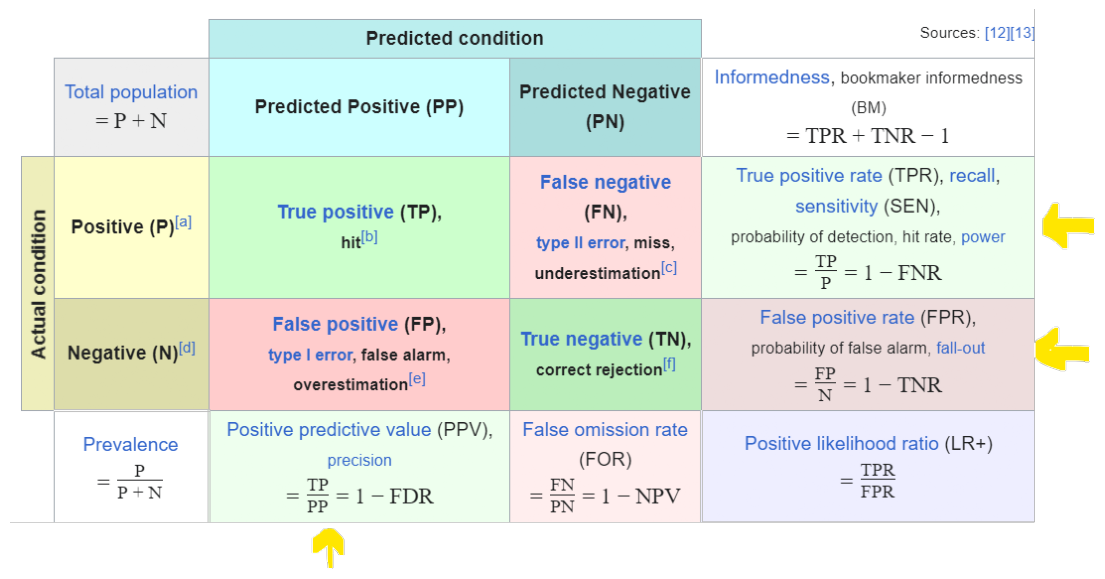

In [31]:
# Load the emvaluation metric image (Source is whikipedia)
# https://www.almabetter.com/bytes/tutorials/data-science/classification-metrics

# visualization. show_image(f'{ROOT_DIR}/figs/confusion_matrix_short_summary.png', figsize=(16,12))
visualization. show_image(f'{ROOT_DIR}/assets/eval_metrics_wiki_short.png', figsize=(14,10))

In [32]:
## Define the scoring metrics
metrics = [precision_score, recall_score, f1_score, balanced_accuracy_score]
classes = ['Inactive', 'Active']  # y values: 0 ('Inactive') - 1 ()'Active')

In [33]:



y_test_desc_pred         = best_desc_lgbm.predict(X_test_desc)
y_test_desc_pred_probas  = best_desc_lgbm.predict_proba(X_test_desc)

cm = confusion_matrix(y_test, y_test_desc_pred)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives = {tn}, False Positives = {fp}, False Negatives = {fn}, True Positives = {tp}\n")

True Negatives = 220, False Positives = 309, False Negatives = 120, True Positives = 699



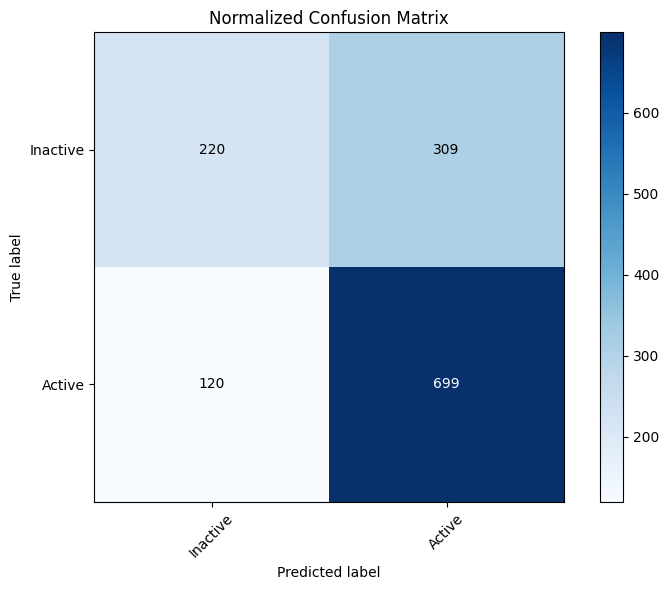

In [34]:
## Plot confusion matrix here
## This makes it easier to interpret the relative performance of the classifier across different classes.
## Each cell now represents the percentage of instances for which the classifier predicted the corresponding class correctly.
visualization.plot_confusion_matrix(y_true=y_test, y_pred=y_test_desc_pred, normalize=False, classes=classes
                                    , title='Normalized Confusion Matrix', cmap=plt.cm.Blues)

As you can see, the predictions are heavaily biased towards the positive class. Keep in mind that there are 1.42 times more active that inactive compounds. The recall is high enough. But the precision is not too bad either.<br>

In [35]:
model_evaluation_desc = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas, metrics + [roc_auc_score], proba_threshold=0.5)

print("Basic metrics\n-------------")
for metric in model_evaluation_desc:
    print(f"{metric:25}: {model_evaluation_desc[metric]}")


Basic metrics
-------------
precision_score          : 0.693
recall_score             : 0.853
f1_score                 : 0.765
balanced_accuracy_score  : 0.635
roc_auc_score            : 0.635


In [36]:
proba_threholds, scores = [0.4, 0.5, 0.6, 0.7, 0.8], []

for t in proba_threholds:
    tr = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas, metrics, proba_threshold=t)
    tr["proba_threshold"] = t
    scores.append(tr)

scores_by_thresholds = pd.DataFrame(scores)
scores_by_thresholds

precision_score  recall_score  f1_score  balanced_accuracy_score  \
0            0.662         0.935     0.775                    0.598   
1            0.693         0.853     0.765                    0.635   
2            0.717         0.729     0.723                    0.641   
3            0.732         0.509     0.600                    0.610   
4            0.739         0.217     0.336                    0.549   

   proba_threshold  
0              0.4  
1              0.5  
2              0.6  
3              0.7  
4              0.8

*Note that we did not compute the roc_auc_score at different thresholds, since it evaluates the model's performance across the entire range of thresholds (0,1), and not just a specific threshold.*

There is often a **trade-off between precision and recall** in binary classification problems. These two metrics are inversely related, meaning that improving one may come at the cost of the other. This trade-off is a fundamental concept in machine learning evaluation, especially when dealing with imbalanced datasets.<br>
<b style="color:orange;"><br>What is more important to you ? Precision or Recall ? </b>Well, it depends: If the cost of false positives is higher than that of false negative, look for higher precision. Otherwise, high recall might be better.
<p ><b>In the current example:</b> We are training a model that predicts small molecule activity agains DD2 growth. The model can be used for screening large compound databases</p>
<ol>
<li><b>We have limited resources</b> to filter out and/or test all the molecules experimentally: <b>Here ,we need to be very confident about the predictions</b>, especially for the compounds predicted as actives:</li>
    <ul><li>A <b>higher precision</b> model mihght be more optimal.</li></ul>
<li>Upon DD2-activity prediction, <b>We have enough resources</b> to either further filter out molecules (e.g.: through ADME prediction) and/or to test hundreds to thousands of molecules. We want to <b>identify as many actives as possible</b></li>
    <ul><li>A <b>higher recall</b> is preferred</li></ul>
</ol>
<br/>

Here are a few other interesting scenarios that highlight this point.
<ol>
<li><b>Metabolite prediction</b></li>
<ul><li>If major metabolites are sought after, for instance to focus on toxicological studies, higher precision models are often expected.</li></ul>
<ul><li>In untargeted metabolomic analysis, it is often OK to predict as many metabolites as possible. The true metabolites can be priorized by comparing predicted vs experimental properties (e.g.: m/z values, collisional cross-section values, retention time, etc.).</li></ul>

<li><b>Lead Optimization</b></li>
<ul><li>After identifying initial hits, chemists focus on optimizing the lead compounds for potency and selectivity. Chemists need to ensure that the compounds chosen for further development have the highest chances of success in clinical trials.</li></ul>
<ul><li>Higher precision is preferred</li></ul>

<li><b>Clinical Trials Design</b></li>
<ul><li>Scientists aim at Designing clinical trials to test the efficacy and safety of a drug candidate.</li></ul>
<ul><li>It is crucial to identify patient subgroups most likely to respond to the treatment (precision) while ensuring the treatment is effective across a broader patient population (recall).</li></ul>
<ul><li>A balance of precision and recall is needed to select patients who are most likely to benefit while minimizing risks.</li></ul><br>
 

<div>
<h3>Curves</h3>
Predicting probabilities instead of classes directly prpvide more flexibility. For instance, in a binary classification tasks, probability thresholds can allow to influence the trade-off of a model in favor of one class. This is required when the cost of one error outweighs the cost of another type pf error. For instance, the precision and recall metric are expected to vary with the probability threshold.

Generally ROC curves and Precision-Recall curves can be used to assess the performance of binary classification models, as They provide insights into how well a classifier is performing and help in selecting the appropriate threshold for making predictions.



<h5>References</h5>
<ol>
<li><a href="https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/">How to Use ROC Curves and Precision-Recall Curves for Classification in Python</a></li>
<li><a href="https://juandelacalle.medium.com/how-and-why-i-switched-from-the-roc-curve-to-the-precision-recall-curve-to-analyze-my-imbalanced-6171da91c6b8">How and Why I Switched from the ROC Curve to the Precision-Recall Curve to Analyze My Imbalanced Models: A Deep Dive</a></li>
<li><a href="https://neptune.ai/blog/balanced-accuracy">Balanced Accuracy: When Should You Use It?</a></li>
</ol>
</div>

<div><br>
<h4>Receiver Operating Characteristic (ROC) Curve</h4>
The ROC Curve focuses on the trade-off between True Positive Rate (TPR, Recall) and False Positive Rate (FPR, fall-out). It shows how well the model distinguishes between positive and negative cases at different classification thresholds.
<ul>
<li> It focuses on the model's performance across various classification thresholds, regardless of the distribution.
<li>ROC curves consider both false positives and false negatives equally important, which is useful when the cost of a false positive is roughly the same as the cost of a false negative</li>
<li>The AUC tells us about the probability that a randomly selected positive instance ranks higher than a randomly selected negative one. A higher AUC (Area Under the Curve) indicates better overall. </li>
</ul>

<p><b style="color:red;">Watch out !!!</b><p>
<ul>
<li>The ROC curve is most suiatable for balanced datasets, and could be misleading if the classs imbalance is severe.</li>
<li>In situations where the dataset is highly imbalanced, the ROC curve can give an overly optimistic assessment of the model’s performance.</li>
</ul>
</div>

In [37]:
## calculating the roc curve

fpr_lgbm_desc, tpr_lgbm_desc, thresholds_lgbm_desc = roc_curve(y_test, y_test_desc_pred_probas[:, 1])  ## y_test_desc_pred_probas[:, 1] We use the probability of class 1, which is the 2 item.
auc_roc_lgbm_desc = auc(fpr_lgbm_desc, tpr_lgbm_desc)
# print(thresholds_rf_desc)


## naive_model: Predicting 0 for every sample
naive_probas_0=[0]*y_test.size
fpr_naive_0, tpr_naive_0, thresholds_naive_0 = roc_curve(y_test, naive_probas_0)

## naive_model: Predicting 1 for every sample
naive_probas_1=[1]*y_test.size
fpr_naive_1, tpr_naive_1, thresholds_naive_1 = roc_curve(y_test, naive_probas_1 )

## perfect model: Predicts the correct label everytime
prefect_probas = y_test
fpr_perfect, tpr_perfect, thresholds_perfect = roc_curve(y_test, prefect_probas )

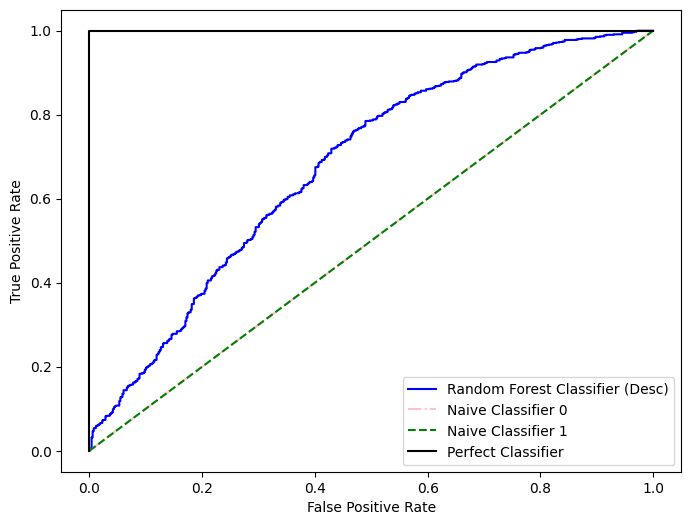


Area Under ROC Curve: 0.68



In [38]:
visualization.plot_curves(x=[fpr_lgbm_desc, fpr_naive_0, fpr_naive_1, fpr_perfect], y=[tpr_lgbm_desc, tpr_naive_0, fpr_naive_1, tpr_perfect]
                # ,  markers=['+', 'v', 'p', 'd']
                , linestyles = ['-', '-.', '--', 'solid']
                , labels=["Random Forest Classifier (Desc)", "Naive Classifier 0", "Naive Classifier 1", "Perfect Classifier"]
                , colors=['blue', 'pink', 'green', 'black'], xlabel='False Positive Rate', ylabel='True Positive Rate'
                , figsize=(8,6), markersize=2)

print(f"\nArea Under ROC Curve: {round(auc_roc_lgbm_desc, 3)}\n")

<div>
Note that:
<ul>
<li>A skilful model will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. The ROC curve for will be closer to the top-left corner of the plot, representing high true positive rate (sensitivity) and low false positive rate. Its shape will closely follows the upper-left boundary of the ROC space, thus increasing the Area Under the curve (AUC).</li>
<li>A weak model has poor predictive power and performs similarly to random guessing. Its ROC curve will be closer to the diagonal line (line of no-discrimination), which represents random guessing.</li>
</div>

<div><br>
<h4>Precision-Recall (PR) Curve</h4>
The Precision-Recall Curve focuses on the trade-off between Precision (positive predictive value) and Recall (sensitivity). 
<ul>
<li>It shows how many of the model's identified positives are actually true positives at different thresholds.
<li>It is better suited when dealing with a significant imbalance in your classes, especially when the minority class (often the positive class) is of greater interest.
<li>A high area under the curve (AUC-PR) indicates both high recall and high precision.</li>
</ul>

<p><b style="color:red;">Watch out !!!</b><p>
<ul>
<li>The PR curve often becomes steeper and harder to interpret at high thresholds. This can make it challenging to assess the model's performance for scenarios requiring a very high level of precision.</li>
<li>Unlike the ROC curve, which has a clear baseline (the diagonal line), the PR curve does not have a definitive baseline for comparison.</li>
</ul>
</div>

In [39]:
precision_lgbm_desc, recall_lgbm_desc, thresholds_lgbm_desc = precision_recall_curve(y_test, y_test_desc_pred_probas[:, 1])
auc_lgbm_desc = auc(recall_lgbm_desc, precision_lgbm_desc)

# print(thresholds_rf_desc)

## naive_model: Predicting 0 for every sample
precision_naive_0, recall_naive_0, thresholds_naive_0 = precision_recall_curve(y_test, naive_probas_0)
auc_naive_0 = auc(recall_naive_0, precision_naive_0)

## naive_model: Predicting 1 for every sample
precision_naive_1, recall_naive_1, thresholds_naive_1 = precision_recall_curve(y_test, naive_probas_1 )
auc_naive_1 = auc(recall_naive_1, precision_naive_1)

## perfect model: Predicts the correct label everytime
precision_perfect, recall_perfect, thresholds_perfect = precision_recall_curve(y_test, prefect_probas )
auc_naive_0 = auc(recall_perfect, precision_perfect)

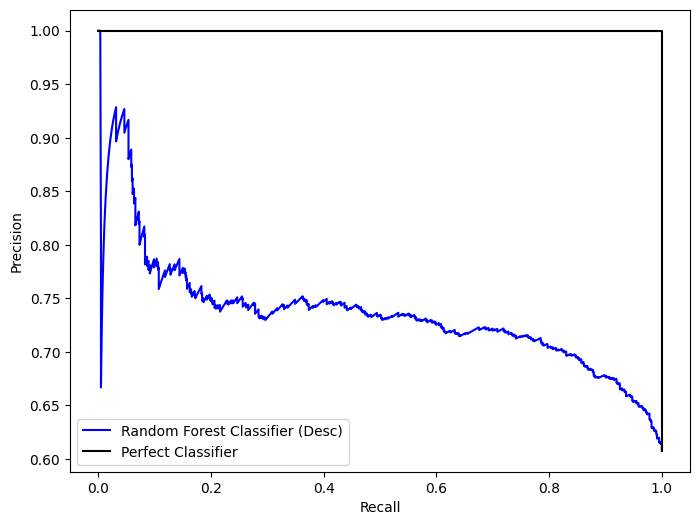


Area Under Precision-Recall Curve: 0.736



In [40]:
visualization.plot_curves(x=[recall_lgbm_desc, recall_perfect], y=[precision_lgbm_desc,  precision_perfect]
                # ,  markers=['+', 'v', 'p', 'd']
                , linestyles = ['-', 'solid']
                , labels=["Random Forest Classifier (Desc)", "Perfect Classifier"]
                , colors=['blue', 'black'], xlabel='Recall', ylabel='Precision'
                , figsize=(8,6), markersize=2)

print(f"\nArea Under Precision-Recall Curve: {round(auc_lgbm_desc, 3)}\n")

<h4>Feautre Importance</h4>
When plotting feature importances, we have the option to display two types of importance measures: "split" and "gain". 
<ol>
<li><b>Split Importance</b> measures the number of times a feature is used to split the data across all trees. It can indicate how often a feature contributes to the overall tree structure. Higher split importance indicates that the feature is frequently used for making decisions in the tree ensemble.</li>
<li><b>Gain Importance</b> measures the average gain (i.e., reduction in the impurity measure such as entropy or Gini impurity) contributed by a feature to the model. It measures the impact of a feature on reducing the model's loss function (e.g., log loss for classification, mean squared error for regression). The higher its importance, the more a feature contributes to improving the model's predictive power.</li>
</ol>

<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

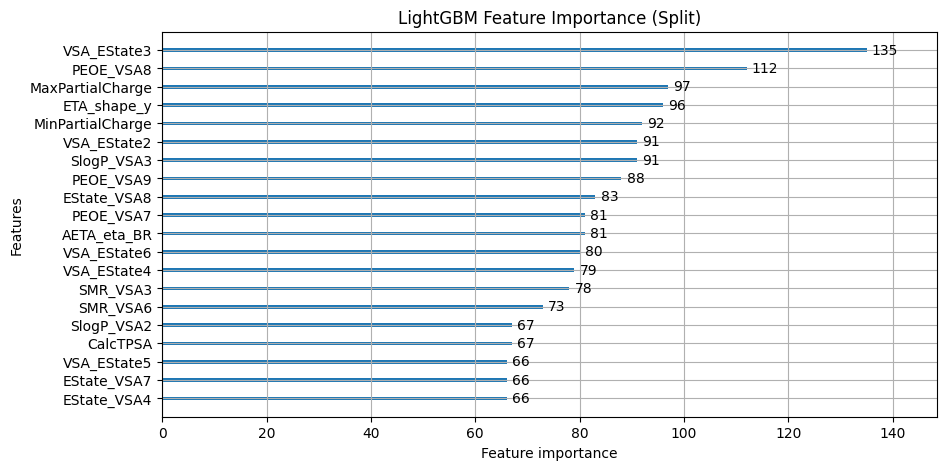

In [41]:
lgbm.plot_importance(best_desc_lgbm, importance_type="split", max_num_features=20, figsize=(10,5), title="LightGBM Feature Importance (Split)")

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

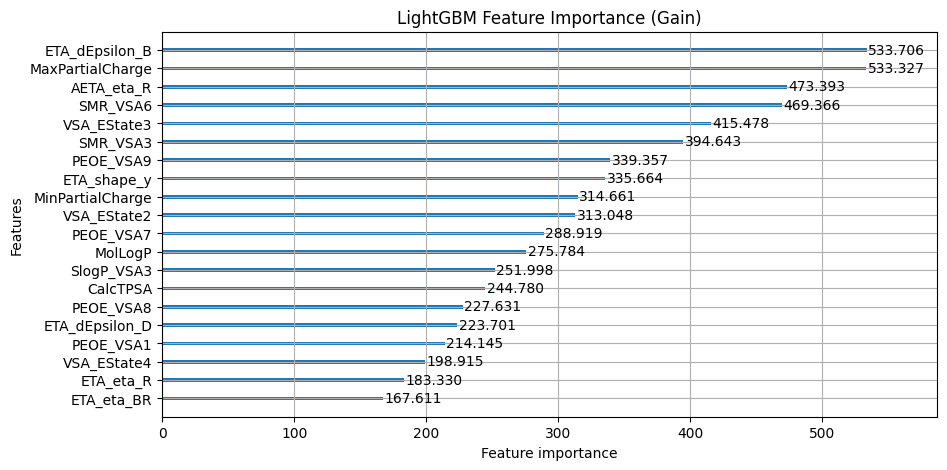

In [42]:
lgbm.plot_importance(best_desc_lgbm, importance_type="gain", max_num_features=20, figsize=(10,5), title="LightGBM Feature Importance (Gain)")

<br><h3>LightGBM with MACCS Fingerprints</h3>

In [43]:
folds_features_maccs = utilities.get_features_for_folds(kfold_splits[0], maccs_fp)
X_test_maccs = folds_features_maccs[0][-1].drop([target_column], axis=1)

train_val_maccs = maccs_fp.iloc[train_val_idx]
X_train_val_maccs = train_val_maccs.drop([target_column], axis=1)
y_train_val_maccs = train_val_maccs[target_column]

X_train_val_maccs.shape, y_train_val_maccs.shape

((12139, 167), (12139,))

In [44]:

results_maccs_lgbm = training.train_with_optuna(model_params_lgbm, num_trials, scoring_function, direction, folds_features_maccs, target_column, standardize=True) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_maccs_lgbm[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_maccs_lgbm[2], 3)}\n\n")


best_maccs_lgbm           = LGBMClassifier(**results_maccs_lgbm[1])
best_maccs_lgbm.fit(X_train_val_maccs, y_train_val_maccs)
utilities.save_to_pkl(best_maccs_lgbm, f"{ROOT_DIR}/models/best_maccs_lgbm.pkl")

y_test_maccs_pred         = best_maccs_lgbm.predict(X_test_maccs)
y_test_maccs_pred_probas  = best_maccs_lgbm.predict_proba(X_test_maccs)

model_evaluation_maccs = evaluation.calculate_binary_class_scores(y_test, y_test_maccs_pred_probas, metrics, proba_threshold=0.5)

print("Basic metrics\n-------------")
for metric in model_evaluation_maccs:
    print(f"{metric:25}: {model_evaluation_maccs[metric]}")

[I 2024-09-05 10:03:46,718] A new study created in memory with name: no-name-6e8ad960-8865-4b9a-a183-ecb175e44aeb


[LightGBM] [Info] Number of positive: 5549, number of negative: 4163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571355 -> initscore=0.287382
[LightGBM] [Info] Start training from score 0.287382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-09-05 10:03:47,391] Trial 0 finished with value: 0.5544255695361469 and parameters: {'n_estimators': 112, 'max_depth': 33, 'num_leaves': 78, 'subsample': 0.8973529927318967, 'min_child_samples': 43, 'min_child_weight': 0.2581575571639242, 'learning_rate': 0.056318444250173426, 'colsample_bytree': 0.3166949658221043, 'reg_alpha': 64, 'reg_lambda': 10, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.08097652363819602, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5544255695361469.


[LightGBM] [Info] Number of positive: 5761, number of negative: 3947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 9708, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593428 -> initscore=0.378155
[LightGBM] [Info] Start training from score 0.378155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-09-05 10:03:48,523] Trial 1 finished with value: 0.5652969065710517 and parameters: {'n_estimators': 501, 'max_depth': 14, 'num_leaves': 32, 'subsample': 0.1948929396613563, 'min_child_samples': 94, 'min_child_weight': 0.14706176758245487, 'learning_rate': 0.35004884920939017, 'colsample_bytree': 0.5865486269935692, 'reg_alpha': 67, 'reg_lambda': 52, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.02399480410144215, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.5652969065710517.


[LightGBM] [Info] Number of positive: 5761, number of negative: 3947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 9708, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593428 -> initscore=0.378155
[LightGBM] [Info] Start training from score 0.378155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-09-05 10:03:50,133] Trial 2 finished with value: 0.5934330278141282 and parameters: {'n_estimators': 773, 'max_depth': 28, 'num_leaves': 81, 'subsample': 0.9591941903043228, 'min_child_samples': 95, 'min_child_weight': 0.6089248275382639, 'learning_rate': 0.4876310104857418, 'colsample_bytree': 0.15387544605441425, 'reg_alpha': 13, 'reg_lambda': 39, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.022456624547424087, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.5934330278141282.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-09-05 10:03:50,937] Trial 3 finished with value: 0.5561649075843983 and parameters: {'n_estimators': 587, 'max_depth': 9, 'num_leaves': 79, 'subsample': 0.2455562049867687, 'min_child_samples': 74, 'min_child_weight': 0.09650171311614272, 'learning_rate': 0.24417166431903992, 'colsample_bytree': 0.8610928948428311, 'reg_alpha': 67, 'reg_lambda': 75, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.07360547336982523, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.5934330278141282.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-09-05 10:03:51,570] Trial 4 finished with value: 0.5529423495363978 and parameters: {'n_estimators': 153, 'max_depth': 37, 'num_leaves': 81, 'subsample': 0.4682214256596712, 'min_child_samples': 85, 'min_child_weight': 0.839932258945982, 'learning_rate': 0.3888473593450498, 'colsample_bytree': 0.2966461403172309, 'reg_alpha': 81, 'reg_lambda': 37, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.088389533886361, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.5934330278141282.


[LightGBM] [Info] Number of positive: 5655, number of negative: 4057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582269 -> initscore=0.332096
[LightGBM] [Info] Start training from score 0.332096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

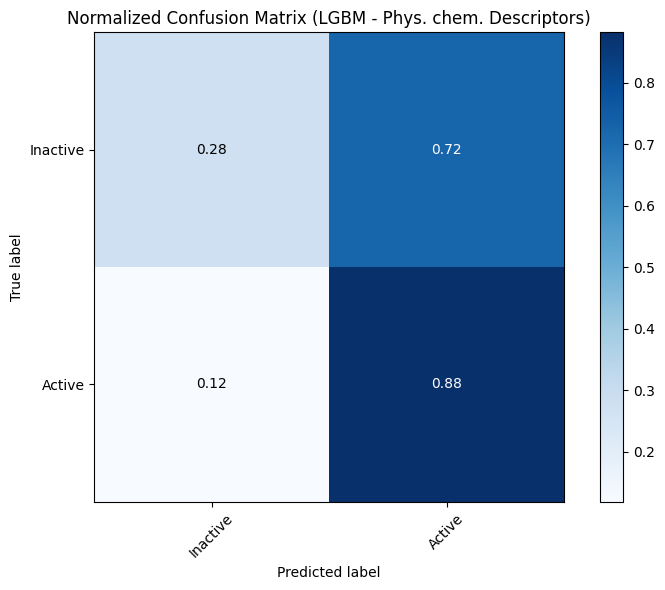

In [45]:
## Plot confusion matrix here

## This makes it easier to interpret the relative performance of the classifier across different classes.
## Each cell now represents the percentage of instances for which the classifier predicted the corresponding class correctly.
visualization.plot_confusion_matrix(y_true=y_test, y_pred=y_test_maccs_pred, normalize=True, classes=classes
                                    , title='Normalized Confusion Matrix (LGBM - Phys. chem. Descriptors)', cmap=plt.cm.Blues)

Normalizing the values in this plot makes it easier to interpret the relative performance of the classifier across different classes. Each cell now represents the percentage of instances for which the classifier predicted the corresponding class correctly.<br>
Here too, the predictions are heavaily biased towards the positive class. Keep in mind that there are 1.42 times more active that inactive compounds. The recall is high enough. But the precision is not too bad either.

<br><h3>LightGBM with Morgan (ECFP) Fingerprints</h3>

It is worth noing that the Fingeprints where obtained using a bit length of 1024, and with counts. Readers are encourage to try using a different bit length (preferrably a power of 2, such as 512 (more compressed), 2048, etc.). One can also opt not to count the occurrence of unique bits per molecule.

In [46]:
folds_features_morgan = utilities.get_features_for_folds(kfold_splits[0], morgan_fp)
X_test_morgan = folds_features_morgan[0][-1].drop([target_column], axis=1)

train_val_morgan = morgan_fp.iloc[train_val_idx]
X_train_val_morgan = train_val_morgan.drop([target_column], axis=1)
y_train_val_morgan = train_val_morgan[target_column]

X_train_val_morgan.shape, y_train_val_morgan.shape

((12139, 1024), (12139,))

In [47]:
%%time

results_morgan_lgbm = training.train_with_optuna(model_params_lgbm, num_trials, scoring_function, direction, folds_features_morgan, target_column, standardize=True) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_morgan_lgbm[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_morgan_lgbm[2], 3)}\n\n")


best_morgan_lgbm           = LGBMClassifier(**results_morgan_lgbm[1])
best_morgan_lgbm.fit(X_train_val_morgan, y_train_val_morgan)
utilities.save_to_pkl(best_morgan_lgbm, f"{ROOT_DIR}/models/best_morgan_lgbm.pkl")

y_test_morgan_pred         = best_morgan_lgbm.predict(X_test_morgan)
y_test_morgan_pred_probas  = best_morgan_lgbm.predict_proba(X_test_morgan)

model_evaluation_morgan = evaluation.calculate_binary_class_scores(y_test, y_test_morgan_pred_probas, metrics, proba_threshold=0.5)

print("Basic metrics\n-------------")
for metric in model_evaluation_morgan:
    print(f"{metric:25}: {model_evaluation_morgan[metric]}")

print("\n\n")

[I 2024-09-05 10:03:52,968] A new study created in memory with name: no-name-9da453ef-8936-498a-9734-f276fc6e7fe4


[LightGBM] [Info] Number of positive: 5549, number of negative: 4163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571355 -> initscore=0.287382
[LightGBM] [Info] Start training from score 0.287382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-09-05 10:03:56,893] Trial 0 finished with value: 0.5499166458597367 and parameters: {'n_estimators': 139, 'max_depth': 14, 'num_leaves': 48, 'subsample': 0.1995053333912969, 'min_child_samples': 28, 'min_child_weight': 0.20529760145636713, 'learning_rate': 0.09210498225675984, 'colsample_bytree': 0.5835673095093781, 'reg_alpha': 77, 'reg_lambda': 54, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'gain', 'min_split_gain': 0.024207399681272078, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5499166458597367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-09-05 10:04:00,248] Trial 1 finished with value: 0.5310062365241982 and parameters: {'n_estimators': 165, 'max_depth': 43, 'num_leaves': 39, 'subsample': 0.251462490569642, 'min_child_samples': 94, 'min_child_weight': 0.6390851084739662, 'learning_rate': 0.2407306767728733, 'colsample_bytree': 0.356759342713752, 'reg_alpha': 97, 'reg_lambda': 18, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.018569201309465676, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5499166458597367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of positive: 5549, number of negative: 4163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 971
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571355 -> initscore=0.287382
[LightGBM] [Info] Start training from score 0.287382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-09-05 10:04:06,781] Trial 2 finished with value: 0.5496921693881974 and parameters: {'n_estimators': 795, 'max_depth': 43, 'num_leaves': 52, 'subsample': 0.39550524038608503, 'min_child_samples': 40, 'min_child_weight': 0.5567298173537807, 'learning_rate': 0.455896473614704, 'colsample_bytree': 0.2824047887656639, 'reg_alpha': 67, 'reg_lambda': 68, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.05563264740262653, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5499166458597367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-09-05 10:04:10,135] Trial 3 finished with value: 0.5813434902541894 and parameters: {'n_estimators': 501, 'max_depth': 27, 'num_leaves': 77, 'subsample': 0.18951860282069488, 'min_child_samples': 22, 'min_child_weight': 0.8604238673609116, 'learning_rate': 0.26046670375534453, 'colsample_bytree': 0.7087073628077086, 'reg_alpha': 47, 'reg_lambda': 40, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.036960840161863046, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.5813434902541894.


[LightGBM] [Info] Number of positive: 5761, number of negative: 3947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 9708, number of used features: 1014
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593428 -> initscore=0.378155
[LightGBM] [Info] Start training from score 0.378155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-09-05 10:04:14,072] Trial 4 finished with value: 0.5509746551798879 and parameters: {'n_estimators': 354, 'max_depth': 36, 'num_leaves': 78, 'subsample': 0.9184660270876782, 'min_child_samples': 90, 'min_child_weight': 0.03728809631117259, 'learning_rate': 0.4168289629014556, 'colsample_bytree': 0.21562118726754714, 'reg_alpha': 74, 'reg_lambda': 2, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.06523641632502085, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.5813434902541894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<h3>LightGBM with combined descriptors</h3>

In [48]:
mols_desc_maccs_morgan = pd.concat([mol_features.drop([target_column], axis=1), maccs_fp.drop([target_column], axis=1), morgan_fp], axis=1)

print(mols_desc_maccs_morgan.iloc[:5,385:390])

folds_features_desc_maccs_morgan = utilities.get_features_for_folds(kfold_splits[0], mols_desc_maccs_morgan)
X_test_desc_maccs_morgan   = folds_features_desc_maccs_morgan[0][-1].drop([target_column], axis=1)
train_val_desc_maccs_morgan = mols_desc_maccs_morgan.iloc[train_val_idx]
X_train_val_desc_maccs_morgan = train_val_desc_maccs_morgan.drop([target_column], axis=1)
y_train_val_desc_maccs_morgan = train_val_desc_maccs_morgan[target_column]


# X_train_val_desc_maccs_morgan['lipinski_ro5'] = X_train_val_desc_maccs_morgan['lipinski_ro5'].astype(bool)
# X_test_desc_maccs_morgan['lipinski_ro5'] = X_test_desc_maccs_morgan['lipinski_ro5'].astype(bool)
# print(X_train_val_desc_maccs_morgan['lipinski_ro5'].dtype, train_val_desc_maccs_morgan.shape)
# # X_train_val_desc_maccs_morgan.head().iloc[:,215:]

   fp_morgan_3  fp_morgan_4  fp_morgan_5  fp_morgan_6  fp_morgan_7
0            0            0            0            0            0
1            0            0            0            0            0
2            0            0            0            0            0
3            0            0            0            0            0
4            0            0            0            0            0


In [49]:
%%time
num_trials = 1
results_desc_maccs_morgan_lgbm = training.train_with_optuna(model_params_lgbm, num_trials, scoring_function, direction
                                                            , folds_features_desc_maccs_morgan, target_column
                                                            , standardize=True) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_desc_maccs_morgan_lgbm[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_desc_maccs_morgan_lgbm[2], 3)}\n\n")




best_desc_maccs_morgan_lgbm           = LGBMClassifier(**results_desc_maccs_morgan_lgbm[1])
best_desc_maccs_morgan_lgbm.fit(X_train_val_desc_maccs_morgan, y_train_val_desc_maccs_morgan)
utilities.save_to_pkl(best_desc_maccs_morgan_lgbm, f"{ROOT_DIR}/models/best_desc_maccs_morgan_lgbm.pkl")

y_test_desc_maccs_morgan_pred         = best_desc_maccs_morgan_lgbm.predict(X_test_desc_maccs_morgan)
y_test_desc_maccs_morgan_pred_probas  = best_desc_maccs_morgan_lgbm.predict_proba(X_test_desc_maccs_morgan)

model_evaluation_desc_maccs_morgan = evaluation.calculate_binary_class_scores(y_test, y_test_desc_maccs_morgan_pred_probas, metrics, proba_threshold=0.5)

print("Basic metrics\n-------------")
for metric in model_evaluation_desc_maccs_morgan:
    print(f"{metric:25}: {model_evaluation_desc_maccs_morgan[metric]}")

print("\n\n")

[I 2024-09-05 10:04:15,402] A new study created in memory with name: no-name-43cd5b84-86bb-41bd-8095-f3961660f769


[LightGBM] [Info] Number of positive: 5549, number of negative: 4163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28962
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 1030
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571355 -> initscore=0.287382
[LightGBM] [Info] Start training from score 0.287382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-09-05 10:04:22,243] Trial 0 finished with value: 0.5996133748911838 and parameters: {'n_estimators': 339, 'max_depth': 41, 'num_leaves': 44, 'subsample': 0.4657093833919277, 'min_child_samples': 100, 'min_child_weight': 0.9977934515969041, 'learning_rate': 0.3140320446007027, 'colsample_bytree': 0.38460515300057463, 'reg_alpha': 59, 'reg_lambda': 42, 'random_state': 3, 'n_jobs': 8, 'objective': 'binary', 'importance_type': 'split', 'min_split_gain': 0.05488005426726234, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5996133748911838.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<h3>Comparing the models using various curves</h3>

In [50]:
### ROC AND PR Curves Data

### MACCS FP

fpr_lgbm_maccs, tpr_lgbm_maccs, thresholds_lgbm_desc = roc_curve(y_test, y_test_maccs_pred_probas[:, 1])  ## y_test_desc_pred_probas[:, 1] We use the probability of class 1, which is the 2 item.
auc_roc_lgbm_maccs = auc(fpr_lgbm_maccs, tpr_lgbm_maccs)

precision_lgbm_maccs, recall_lgbm_maccs, thresholds_lgbm_maccs = precision_recall_curve(y_test, y_test_maccs_pred_probas[:, 1])
auc_lgbm_maccs = auc(recall_lgbm_maccs, precision_lgbm_maccs)


### MORGAN FP

fpr_lgbm_morgan, tpr_lgbm_morgan, thresholds_lgbm_dmorgan = roc_curve(y_test, y_test_morgan_pred_probas[:, 1])  ## y_test_desc_pred_probas[:, 1] We use the probability of class 1, which is the 2 item.
auc_roc_lgbm_morgan = auc(fpr_lgbm_morgan, tpr_lgbm_morgan)

precision_lgbm_morgan, recall_lgbm_morgan, thresholds_lgbm_morgan = precision_recall_curve(y_test, y_test_morgan_pred_probas[:, 1])
auc_lgbm_morgan = auc(recall_lgbm_morgan, precision_lgbm_morgan)


### DESC + MORGAN FP + MACCS FP

fpr_lgbm_desc_maccs_morgan, tpr_lgbm_desc_maccs_morgan, thresholds_lgbm_desc_maccs_morgan = roc_curve(y_test, y_test_desc_maccs_morgan_pred_probas[:, 1])  ## y_test_desc_pred_probas[:, 1] We use the probability of class 1, which is the 2 item.
auc_roc_lgbm_desc_maccs_morgan = auc(fpr_lgbm_desc_maccs_morgan, tpr_lgbm_desc_maccs_morgan)

precision_lgbm_desc_maccs_morgan, recall_lgbm_desc_maccs_morgan, thresholds_lgbm_desc_maccs_morgan = precision_recall_curve(y_test, y_test_desc_maccs_morgan_pred_probas[:, 1])
auc_lgbm_desc_maccs_morgan = auc(recall_lgbm_desc_maccs_morgan, precision_lgbm_desc_maccs_morgan)

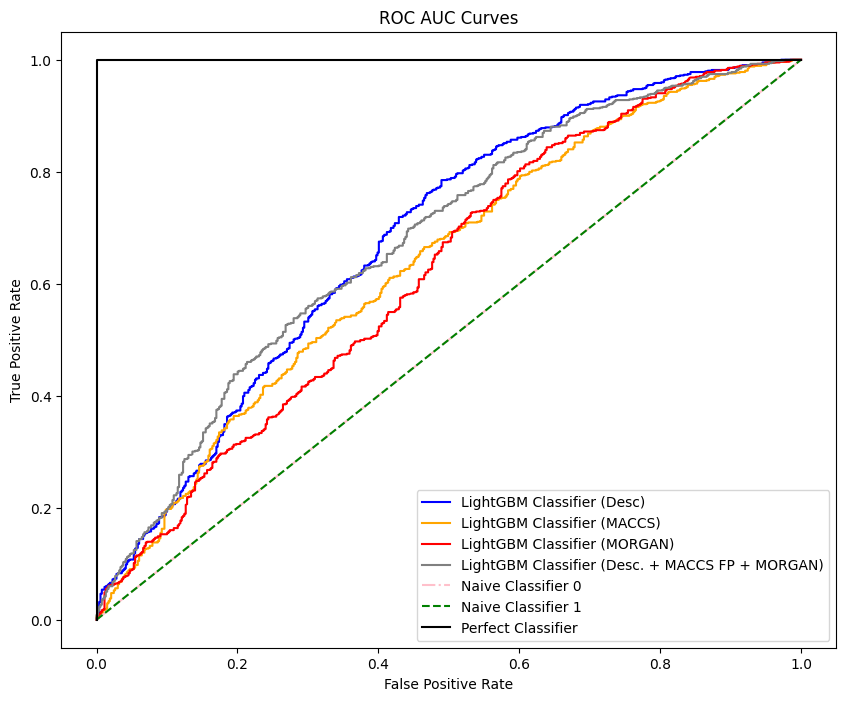


Area Under ROC Curve (Desc):                      0.68
Area Under ROC Curve (MACCS):                     0.636
Area Under ROC Curve (MORGAN):                    0.621
Area Under ROC Curve (Desc. + MACCS FP + MORGAN): 0.677



In [51]:
visualization.plot_curves(x=[fpr_lgbm_desc, fpr_lgbm_maccs, fpr_lgbm_morgan, fpr_lgbm_desc_maccs_morgan, fpr_naive_0, fpr_naive_1, fpr_perfect], y=[tpr_lgbm_desc, tpr_lgbm_maccs, tpr_lgbm_morgan, tpr_lgbm_desc_maccs_morgan, tpr_naive_0, fpr_naive_1, tpr_perfect]
                # ,  markers=['+', 'v', 'p', 'd']
                , linestyles = ['-', '-', '-', '-', '-.', '--', 'solid']
                , labels=["LightGBM Classifier (Desc)", "LightGBM Classifier (MACCS)", "LightGBM Classifier (MORGAN)", "LightGBM Classifier (Desc. + MACCS FP + MORGAN)", "Naive Classifier 0", "Naive Classifier 1", "Perfect Classifier"]
                , colors=['blue', 'orange', 'red', 'grey', 'pink', 'green', 'black'], xlabel='False Positive Rate', ylabel='True Positive Rate'
                , title="ROC AUC Curves"
                , figsize=(10,8), markersize=2)

print(f"\nArea Under ROC Curve (Desc):                      {round(auc_roc_lgbm_desc, 3)}")
print(f"Area Under ROC Curve (MACCS):                     {round(auc_roc_lgbm_maccs, 3)}")
print(f"Area Under ROC Curve (MORGAN):                    {round(auc_roc_lgbm_morgan, 3)}")
print(f"Area Under ROC Curve (Desc. + MACCS FP + MORGAN): {round(auc_roc_lgbm_desc_maccs_morgan, 3)}\n")

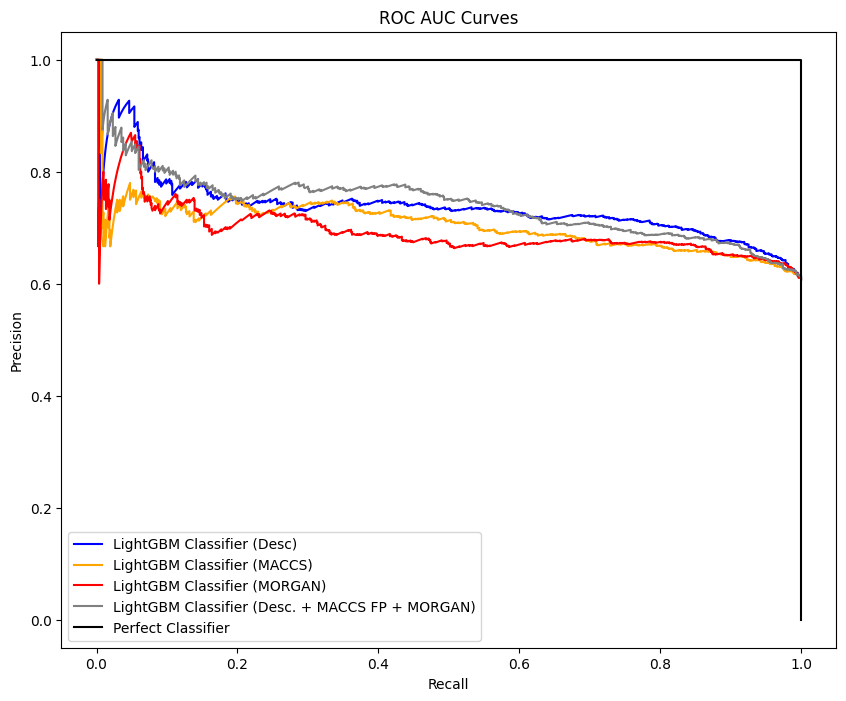


Area Under Precision-Recall Curve (Desc):  0.736
Area Under Precision-Recall Curve (MACCS): 0.703
Area Under Precision-Recall Curve (MORGAN: 0.693
Area Under Precision-Recall Curve (Desc. + MACCS FP + MORGAN): 0.74


In [52]:
visualization.plot_curves(x=[recall_lgbm_desc, recall_lgbm_maccs, recall_lgbm_morgan, recall_lgbm_desc_maccs_morgan, recall_perfect]
                          , y=[precision_lgbm_desc, precision_lgbm_maccs, precision_lgbm_morgan, precision_lgbm_desc_maccs_morgan, tpr_perfect]
                # ,  markers=['+', 'v', 'p', 'd']
                , linestyles = ['-', '-', '-', '-', 'solid']
                , labels=["LightGBM Classifier (Desc)", "LightGBM Classifier (MACCS)", "LightGBM Classifier (MORGAN)", "LightGBM Classifier (Desc. + MACCS FP + MORGAN)", "Perfect Classifier"]
                , colors=['blue', 'orange', 'red', 'grey', 'black'], xlabel='Recall', ylabel='Precision'
                , title="ROC AUC Curves"
                , figsize=(10,8), markersize=2)

print(f"\nArea Under Precision-Recall Curve (Desc):  {round(auc_lgbm_desc, 3)}")
print(f"Area Under Precision-Recall Curve (MACCS): {round(auc_lgbm_maccs, 3)}")
print(f"Area Under Precision-Recall Curve (MORGAN: {round(auc_lgbm_morgan, 3)}")
print(f"Area Under Precision-Recall Curve (Desc. + MACCS FP + MORGAN): {round(auc_lgbm_desc_maccs_morgan, 3)}")

<h2>Explaining Our Model Predictions With Shapley Values</h2>

Explaining the predictions of a machine learning model is crucial for several reasons:

1. **Understanding "why"**: Explanations provide insights into why a model makes a particular prediction, making the model's decisions more transparent.
2. **Interpretability:** Explanations make complex models more interpretable for non-expert users, such as doctors using a medical diagnosis model.
3. **Building Trust:** Users, stakeholders, and regulators are more likely to trust a model when they can understand and verify its reasoning. 
4. **Identifying Model Biases:** Explanations help identify biases in the model. The model predictions must be predictions are unbiased and not implicitely or explicitely discriminate against certain groups or features.
5. **Model Improvement:** Insights from explanations can guide model refinement, helping developers address weaknesses and improve performance.
6. **Compliance Requirements:** Some industries have regulatory requirements that demand explainable models
7. **Fairness:** Making sure the predictions are unbiased and do not implicitely or explicitely discriminate against protected groups.
    
    
\
We will use the [**SHAP (SHapley Additive exPlanations)**](https://shap.readthedocs.io/en/latest/)
* SHAP is a Python library for model interpretation and explaining the output of machine learning models.


\
**Imagine the features (e.g.: temperature, humidity) as players in a cooperative game.**
* Each player contributes some value to the final prediction (e.g., model's output).
* Shapley values determine how much credit each feature deserves for the final outcome, considering all possible orderings in which these "players" could have joined the game and contributed their information.
* This process ensures that features contributing to the prediction early on and those providing crucial information in complex interactions with other features are appropriately recognized.

**Intepretation**
* Positive Shapley value: The feature generally contributes positively to the prediction.
* Negative Shapley value: The feature generally contributes negatively to the prediction.
*  High magnitude (absolute value): The feature has a significant impact on the prediction, either positive or negative.
* Low magnitude: The feature has a less significant impact on the prediction.

**Benefits**
* It is Model Agnostic: Works with any machine learning model, including tree-based models, linear models, neural networks, and more.
* Global and Local Explanations: Offers insights into both global model behavior and individual predictions.



#### References
1. [The Art of Explaining Predictions](https://towardsdatascience.com/the-art-of-explaining-predictions-22e3584ed7d8)
2. [Explain your model predictions with Shapley Values](https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook)

In [53]:
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_desc_maccs_morgan_lgbm)
shap_values = explainer.shap_values(X_train_val_desc_maccs_morgan)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<br><h3>SHAP Explanation Force Plots</h3>
These plots are used to **explain individual predictions**. It shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue.
<ul>
<li>In the example below, MolLogP are pushing the prediction higher towards activity, while fp_morgan_664 is pushing towards inactivity.</li>
</ul>


In [54]:
# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][0,:], X_train_val_desc_maccs_morgan.iloc[0,:])

<br><h3>SHAP Feature Importance</h3>
The Feature Importance plot **shows a global interpretation of the model**. Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data. Features are sorted by the sum of the SHAP value magnitudes across all samples.
<ul>
<li>In the example below, the AETA_dEpsilon_B feature contributes the most towards predictive activity.</li>
</ul>

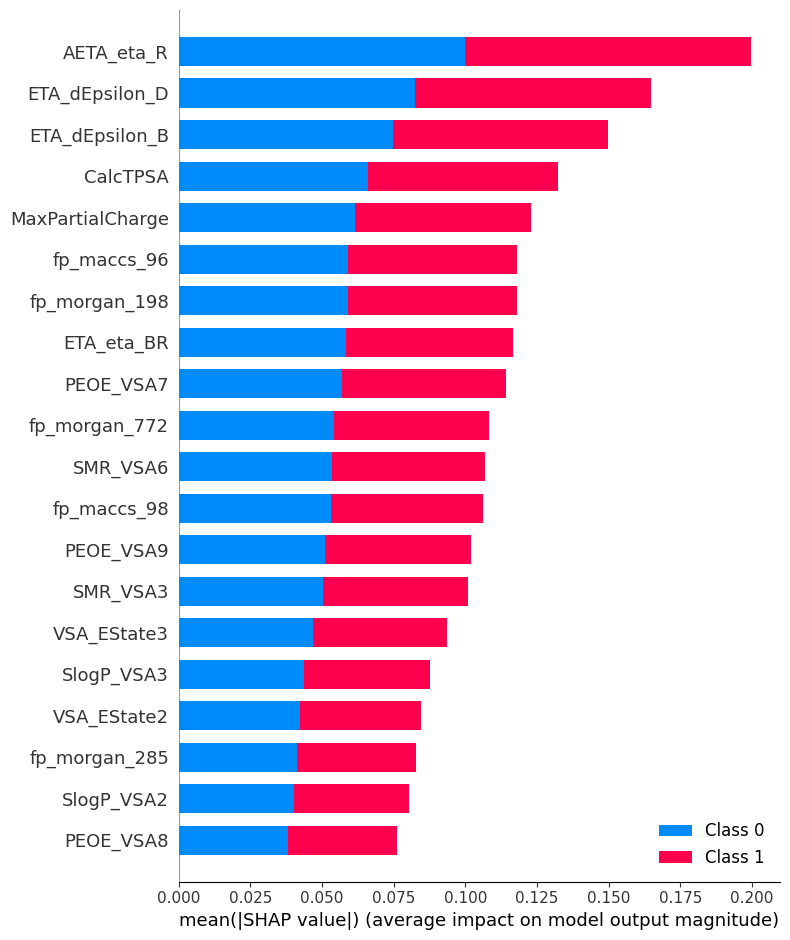

In [55]:
shap.summary_plot(shap_values, X_train_val_desc_maccs_morgan, plot_type="bar")

<h2>Learning a Meta Classifier</h2>
A meta-learner is a type of ensemble learning technique where multiple base models are combined to make predictions. Unlike traditional ensemble methods like bagging or boosting, which combine predictions from multiple models of the same type, meta-learners combine predictions from diverse base models.
* They tend to achieve better generalixation, and predictive performance, compared to individual base models.
* They can capture complex, non-linear relationships in the data. Each base model may excel in capturing certain patterns, and the meta-learner can combine these strengths for improved predictions.
* By combining predictions from multiple models, meta-learners can reduce the risk of overfitting.

Examples of meta-learners capable of leveraging different classes of base learners include Stacking and Voting meta-learners
* **Stacking meta-learners** stack multiple base estimators and a final meta-estimator. The predictions of the base estimators are used as input features for the final estimator. The final estimator is trained to make predictions based on these inputs.
* **Voting meta-learners** combine the predictions of multiple base estimators using either a majority vote (for classification) or averaging (for regression). The voting mode can be **hard** (for classifiers, counting the most commonly predicted classes) or **soft** (classifiers with probability estimates.)\

We will train a [RandomForest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and a [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) that take the descriptors (RDKit, Mordred, and added customized features) as molecular representations. Tehse models will be used as base estimators, and the meta-classifier will be a Logistic Regressor.

##### References
* [Stacking Classifiers for Higher Predictive Performance](https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840)

In [56]:
from sklearn.ensemble import StackingClassifier

<h3>Training Additional Models</h3>
<h4>Random Forest with RDKit and Mordred Descriptors</h4>

In [57]:
model_params_rf = {
    'model': RandomForestClassifier,
    'params': {
        'n_estimators': (50, 2000),
        'max_depth': (2, 100),
        'min_samples_split': (2, 100),
        'min_impurity_decrease': (0, 0.0001),
        'max_features': (0.3, 1.0),
        # 'bootstrap': (True, False), # Make sure to set
        'bootstrap':True,
        'random_state': seed,
        'class_weight':('balanced', 'balanced_subsample'),
        'n_jobs':8   
    }
}


# num_trials = 1
results_desc_rf = training.train_with_optuna(model_params_rf, num_trials, scoring_function, direction, folds_features_desc, target_column, standardize=False) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_desc_rf[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_desc_rf[2], 3)}\n\n")


best_desc_rf           =  RandomForestClassifier(**results_desc_rf[1])
best_desc_rf.fit(X_train_val_desc, y_train_val_desc)
utilities.save_to_pkl(best_desc_rf, f"{ROOT_DIR}/models/best_desc_rf.pkl")

y_test_desc_pred_rf         = best_desc_rf.predict(X_test_desc)
y_test_desc_pred_probas_rf  = best_desc_rf.predict_proba(X_test_desc)

model_evaluation_desc_rf = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas_rf, metrics, proba_threshold=0.5)

[I 2024-09-05 10:04:26,391] A new study created in memory with name: no-name-b12e6a64-8f25-4e8a-8301-e4e63425c47f
[I 2024-09-05 10:10:10,427] Trial 0 finished with value: 0.6481672822373783 and parameters: {'n_estimators': 1211, 'max_depth': 52, 'min_samples_split': 9, 'min_impurity_decrease': 0, 'max_features': 0.6950420788058007, 'bootstrap': True, 'random_state': 3, 'class_weight': 'balanced', 'n_jobs': 8}. Best is trial 0 with value: 0.6481672822373783.



-------
Results
-------
Best Parameters: {'n_estimators': 1211, 'max_depth': 52, 'min_samples_split': 9, 'min_impurity_decrease': 0, 'max_features': 0.6950420788058007, 'bootstrap': True, 'random_state': 3, 'class_weight': 'balanced', 'n_jobs': 8}
Best validation score (balanced_accuracy_score): 0.648




<h4>K-Nearest Neighbors with RDKit and Mordred Descriptors</h4>

In [58]:
%%time
from sklearn.neighbors import KNeighborsClassifier

model_params_knn = {
    'model': KNeighborsClassifier,
    'params': {
        'n_neighbors': (3, 10),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree'],
        'leaf_size': (30, 50),
        'p': (1, 30),
        'metric': ['minkowski', 'jaccard'],
        'n_jobs':8
    }
}

results_desc_knn = training.train_with_optuna(model_params_knn, num_trials, scoring_function, direction
                                               , folds_features_desc, target_column, standardize=True) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_desc_knn[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_desc_knn[2], 3)}\n\n")


best_desc_knn           = KNeighborsClassifier(**results_desc_knn[1])
best_desc_knn.fit(X_train_val_desc, y_train_val_desc)
utilities.save_to_pkl(best_desc_knn, f"{ROOT_DIR}/models/best_desc_knn.pkl")

y_test_desc_pred_knn         = best_desc_knn.predict(X_test_desc)
y_test_desc_pred_probas_knn  = best_desc_knn.predict_proba(X_test_desc)

model_evaluation_desc_knn = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas_knn, metrics, proba_threshold=0.5)

[I 2024-09-05 10:13:11,144] A new study created in memory with name: no-name-905f1f4e-0dfb-4dc1-a3bd-67ecc9c80782
[I 2024-09-05 10:13:17,973] Trial 0 finished with value: 0.5 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 43, 'p': 10, 'metric': 'jaccard', 'n_jobs': 8}. Best is trial 0 with value: 0.5.



-------
Results
-------
Best Parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 43, 'p': 10, 'metric': 'jaccard', 'n_jobs': 8}
Best validation score (balanced_accuracy_score): 0.5


CPU times: user 56.2 s, sys: 60.1 ms, total: 56.3 s
Wall time: 8.94 s


<h4>Support Vector Classifier with RDKit and Mordred Descriptors</h4>
We will run a shorter training process, as SVCs usually take much longer. Moreover, we have not selected any features.
<p style="color:red"><b>WARNING!!!</b> Support Vector Machines requires significantly more time and resource to train.</p>

In [59]:
from sklearn.svm import SVC
model_params_svc = {
    'model': SVC,
    'params': {
        'class_weight': 'balanced',
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
        , 'probability': "True"  ## must be set to true so that we can call predict_proba() on the svc model

    }
}

results_desc_svc = training.train_with_optuna(model_params_svc, num_trials, scoring_function, direction, folds_features_desc, target_column, standardize=True) ## The values count occurrences. It might be wise to standardize them.

print("\n-------\nResults\n-------")
print(f"Best Parameters: {results_desc_svc[1]}")
print(f"Best validation score ({scoring_function.__name__}): {round(results_desc_svc[2], 3)}\n\n")


best_desc_svc           = SVC(**results_desc_svc[1])
best_desc_svc.fit(X_train_val_desc, y_train_val_desc)
utilities.save_to_pkl(best_desc_svc, f"{ROOT_DIR}/models/best_desc_svc.pkl")

y_test_desc_pred_svc         = best_desc_svc.predict(X_test_desc)
y_test_desc_pred_probas_svc  = best_desc_svc.predict_proba(X_test_desc)

model_evaluation_desc_svc = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas_svc, metrics, proba_threshold=0.5)

[I 2024-09-05 10:13:20,110] A new study created in memory with name: no-name-f0c7428f-e331-4fb0-a41c-3b1d60ec5d62
[I 2024-09-05 10:17:47,495] Trial 0 finished with value: 0.6185114767322848 and parameters: {'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly', 'probability': True}. Best is trial 0 with value: 0.6185114767322848.


<h3>Training The Meta Learner Model</h3>

In [ ]:
from sklearn.linear_model import LogisticRegression


base_classifiers_ = [('rf', best_desc_rf), ('lgbm', best_desc_lgbm), ('svc', best_desc_svc), ('knn', best_desc_knn)]

### For the final model use logistic regression that returns the probability for the class 1. 
### If you use SVC for the final model, make sure to set probabilities=True when creating the model.
meta_classifier_  = LogisticRegression()

stacking_classifier_rf_lgbm_desc_ = StackingClassifier(estimators=base_classifiers_, final_estimator=meta_classifier_, cv=5)
stacking_classifier_rf_lgbm_desc_.fit(X_train_val_desc, y_train_val_desc)

utilities.save_to_pkl(stacking_classifier_rf_lgbm_desc_, f"{ROOT_DIR}/models/stacking_classifier_rf_lgbm_desc_.pkl")

y_test_desc_pred_rf_lgbm         = stacking_classifier_rf_lgbm_desc_.predict(X_test_desc)
y_test_desc_pred_probas_rf_lgbm  = stacking_classifier_rf_lgbm_desc_.predict_proba(X_test_desc)


model_evaluation_desc_rf_lgbm = evaluation.calculate_binary_class_scores(y_test, y_test_desc_pred_probas_rf_lgbm, metrics, proba_threshold=0.5)

[LightGBM] [Info] Number of positive: 7116, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27044
[LightGBM] [Info] Number of data points in the train set: 12139, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.586210 -> initscore=0.348318
[LightGBM] [Info] Start training from score 0.348318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


In [ ]:
print("\nBasic metrics (LGBM w. Desc)\n-----------------------------")
for metric in model_evaluation_maccs:
    print(f"{metric:25}: {model_evaluation_desc[metric]}")


print("\nBasic metrics (Random Forest w. Desc)\n--------------------------------------")
for metric in model_evaluation_desc_rf:
    print(f"{metric:25}: {model_evaluation_desc_rf[metric]}")

print("\nBasic metrics (KNN w. Desc)\n--------------------------------------")
for metric in model_evaluation_desc_knn:
    print(f"{metric:25}: {model_evaluation_desc_knn[metric]}")


print("\n\nBasic metrics (SVC w. Desc)\n-----------------------------")
for metric in model_evaluation_desc_svc:
    print(f"{metric:25}: {model_evaluation_desc_svc[metric]}")


print("\n-------------------------------------\n-Basic metrics (Meta Classifier w. Desc)\n--------------------------------------")
for metric in model_evaluation_desc_rf_lgbm:
    print(f"{metric:25}: {model_evaluation_desc_rf_lgbm[metric]}")   


Basic metrics (LGBM w. Desc)
-----------------------------
precision_score          : 0.697
recall_score             : 0.855
f1_score                 : 0.768
roc_auc_score            : 0.64
balanced_accuracy_score  : 0.64

Basic metrics (Random Forest w. Desc)
--------------------------------------
precision_score          : 0.673
recall_score             : 0.557
f1_score                 : 0.609
roc_auc_score            : 0.569
balanced_accuracy_score  : 0.569

Basic metrics (KNN w. Desc)
--------------------------------------
precision_score          : 0.677
recall_score             : 0.72
f1_score                 : 0.698
roc_auc_score            : 0.595
balanced_accuracy_score  : 0.595


Basic metrics (SVC w. Desc)
-----------------------------
precision_score          : 0.661
recall_score             : 0.85
f1_score                 : 0.744
roc_auc_score            : 0.587
balanced_accuracy_score  : 0.587

-------------------------------------
-Basic metrics (Meta Classifier w. Desc

If you are looking for higher recall, while still keeping a moderately high precision, you might want to choose the meta classifier. However, it is not significantly better than the LGBM and SVC models. If the F1-score is the metric of choice, the meta-learner is the best model.

<p style="color:red"><b>Keep in mind</b></p>
<ol>
<li>Many observations we made throughout this tutorial reflect the outcomes based on parameters we chose, including the seed, pamameter grids,classification algorithms, and model representations. It is possible that by modifying them, the results might change a bit.</li>
<li>We only trained models for up to 5 steps. Increasing the number of steps could lead to slightly different outcomes.</li>
<li>Moreover, it is recommended to try various classes of models. Consider other types of classical (e.g. SVC, KNN, Gaussian Processes) and deep (e.g Transformers, RNNs, GCNs) learning models.</li>
<li>There exist several libraries suc as AutoGluon, and TPOT which allow you to run automatic machine learning pipelines, with customized configurations. Basically, they implement what we did so far, once you privide your data and configuration.
   <ul>
      <li>Advantages:  They spport a wide range of machine learning tasks and algotithms; they can perform simple data processing tasks (e.g.: standardization); not much coding is required.</li>
      <li>Limitations: Some preprocessing still needs to be done prior to the learning part, since no amount of automation can fully substiture for domain expertise. They can be compputatinoally more expensive; cutomization options might be limited</li>
   </ul>
  </li>
  </ol>

<br><h2>Defining the Applicability Domain</h2>

Because scientists explore subregions of a chemical space that is extremely large (~ 10^60 molecules), it is likely that novel molecules are very different from the ones used to train a prior predictive model. In small-molecule discovery settings, different projects often fous on specific chemical series. Therefore, over time, it is likely that the model(s) become decreasingly applicable/useful. This can be showned by decreasing performance on more recent data. \
One way to know whether a model is fit enough to predict data on a new molecular dataset, is to define its **applicability domain (AD)**.
* It defines the domain or region in which the model's predictions are considered **reliable and accurate**. 
* It provides a **measure of confidence** in the model's predictions for compounds within the AD.
* It prevents the model from **extrapolating**, i.e. making unreliable predictions for compounds that significantly differ from those in the training set.\


There are several methods to define the AD of a QSAR model. Generally, the process goes as follows:
1. Select a set of features/descriptors to represent the molecules. The representation is often the same that was used for model training
2. Select a metric to compute distances
3. Define the distance-based criteria that will determine whether a molecule falls within the applicability domain. In our tutorial, we followed a simple approach:
    * We first created a Nerarest Neighbors model using the whole trin/val set buld only with maccs fingeprints. This model can be used to retrive the *K* closest neighborsto a given data point, based on the selected distance metric(e.g.: Jaccard in our case)
    * We used the model to find the average distance of each training data point to its 5-closes neighbors. We chose the 90th percentile as our starting threshold
    * We when iterate over the test data (YES! test data must fall in the AD, as well). Given that there might be some outliers, and do not need to have evry single data point within the AD,
    * We increase the threshold as long as less than 90% of the training instances fall within the AD. Once the criterium is met, We have our maximum distance *max_dist*
4. Once the *max_dist* is determined, we can use it for any molecule to test. A molecule falls within the model's AD if its average distance to its five nearest neighbors in the training dataset is less than *max_dist*


<br><h3>Training an Applicability Domain Model</h3>

In [ ]:
from lib import applicability

In [ ]:
%%time
desc_training  = X_train_val_desc.iloc[:,:].values
desc_test      = X_test_desc.iloc[:,:].values
my_ad_estimator = applicability.ApplicationDomainEstimator()
my_ad_estimator.train_nn_model(desc_training, leaf_size=None)
print(my_ad_estimator.to_dict())

##
mdist = my_ad_estimator.find_max_distance_treshold(test_data=desc_test, n_neighbors=5)
print(f"mdist = {mdist}")
print(my_ad_estimator.to_dict())

{'nn_model': {'data': (12139, 221)}, 'max_dist': None, 'n_neighbors': None, 'metric': 'jaccard', 'leaf_size': 40}
Min: 0.0 - Max = 0.138 - Avg: 0.018 - 90th-percentile: 0.026
valid_perc_test = 0.096
valid_perc_test = 0.841
valid_perc_test = 0.99
Percentage of training data points with avg. distance to 5-nearest training data neighbors < 0.126: 1.0
Percentage of test data points with avg. distance to 5-nearest training data neighbors  < 0.126: 0.99
mdist = 0.126
{'nn_model': {'data': (12139, 221)}, 'max_dist': 0.126, 'n_neighbors': 5, 'metric': 'jaccard', 'leaf_size': 40}
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s


In [ ]:
## Can we reproduce this? Let's find the percentage of test data points that in the model's applicability domain:
## Upon estimation of the maximum threshold (0.362), an estimated 91.8% of test data points fell into the AD
ds = my_ad_estimator.is_within_ad(desc_test)
ds_sum = sum([int(x) for x in ds])
print(f"Percentage of test data that fall into the AD: {round(ds_sum/len(ds)*100, 1)}%")

Percentage of test data that fall into the AD: 99.0%


<h3>Predicting DD2 Inhibitory Activity For Novel Molecules</h3>
<br>Below, we will predict the inhibitory activity of selected molecules (some of which are from PubChem, and others were 'almost' randomly generated). We will also estimate whether they fall into the applicability domain.

In [ ]:
molecules = [MolFromSmiles(x) for x in ['CCC1=CC2=C(C=C1Cl)N=C(C(=N2)C3=C(C=CC(=C3)Br)O)C4=C(C=CC(=C4)Br)OCC'
                                        , 'C1=CC=C(C=C1)C=O', 'C1=CC=C(C=C1)COC(=O)C2=CC=CC=C2'
                                        , 'C1=CC=C(C=C1)C2=CC=C(C=C2)C3=NNC(=C3)C(=O)NN=CC4=CNC5=CC=CC=C54'
                                        , 'C(CO)CC1=CC=C2C(=C1)C(=CC(=N2)C3=C(C=C(C=C3)Br)O)N'
                                        , 'C1CCN(CC1)C(=O)C2=NN3C(CC(NC3=C2)C4=CC=C(C=C4)F)C(F)(F)F'
                                        , 'C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O'
                                        , 'CC(=C)[C@H]1CC2=C(O1)C=CC3=C2O[C@@H]4COC5=CC(=C(C=C5[C@@H]4C3=O)OC)OC'
                                        , 'CC(C)CCC1=CCCCC1'
                                        , 'CC(=O)NC1CCC2=CC(=C(C(=C2C3=CC=C(C(=O)C=C13)OC)OC)OC)OC'
                                          ]
            ]


# mol_reps = np.array([np.array(x) for x in featurizers.calculate_fingerprints(molecules, fingerprint_type="maccs")])

features_ = [
                'CalcExactMolWt'
                , 'CalcTPSA', 'CalcNumAromaticRings', 'CalcNumAliphaticRings', 'CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'qed'
                , 'CalcNumRotatableBonds', 'CalcNumAmideBonds'
                , 'MolLogP', 'HallKierAlpha', 'MaxPartialCharge', 'MinPartialCharge'
                , 'ExtendedTopochemicalAtom'
                , 'Polarizability'
                , 'ZagrebIndex'
                , 'MoeType'
            ]
mol_featurizer = featurizers.MoleculeFeaturizer(features = None)
mol_features = mol_featurizer.compute_properties_for_mols(molecules=molecules, as_dataframe=True, count_unique_bits=False)
mol_features['Mol'] = molecules
mol_features = preprocessing.add_custom_features(mol_features, bool_to_int=True, mol_column='Mol')
mol_features.drop(['Mol'], axis=1, inplace=True)
mol_features.head(2)

RDKIT property calculation: 0.145 seconds.


100%|██████████| 10/10 [00:00<00:00, 36.83it/s]

MORDRED property calculation: 0.865 seconds.


CalcExactMolWt  CalcTPSA  CalcNumAromaticRings  CalcNumAliphaticRings  \
0      559.950180     55.24                     4                      0   
1      106.041865     17.07                     1                      0   

   CalcNumAliphaticCarbocycles  CalcNumAliphaticHeterocycles  \
0                            0                             0   
1                            0                             0   

   CalcNumLipinskiHBA  CalcNumLipinskiHBD  CalcNumHBA  CalcNumHBD  ...  \
0                   4                   1           4           1  ...   
1                   1                   0           1           0  ...   

   VSA_EState5  VSA_EState6  VSA_EState7  VSA_EState8  VSA_EState9  \
0     0.807497    14.818517     0.787493     4.495578          0.0   
1     0.000000     9.097685     0.833333     0.000000          0.0   

   num_halo_atoms  halo_weight_ratio  num_s3_carbons  frac_spe_carbons  \
0               3           0.347014               7          0.225806   
1               0           0.000000               0          0.000000   

   lipinski_ro5  
0             0  
1             1  

[2 rows x 221 columns]

[0.64, 0.42, 0.22, 0.55, 0.9, 0.82, 0.56, 0.73, 0.53, 0.72]


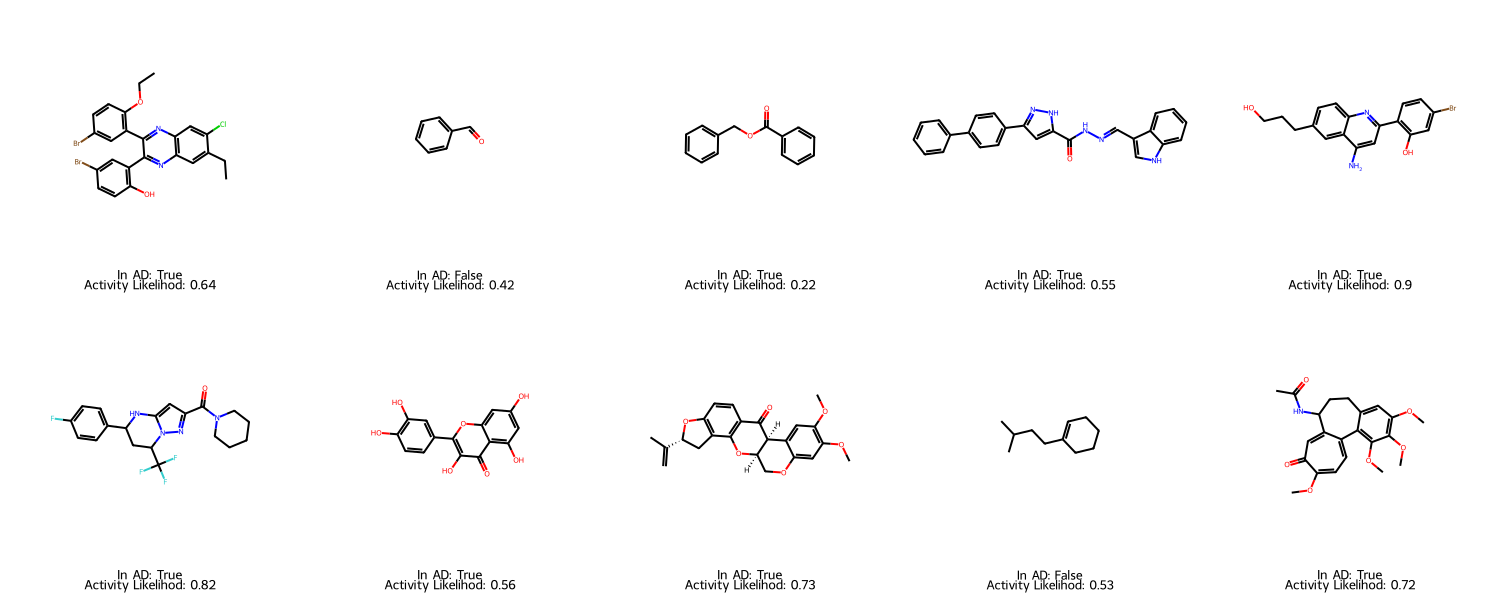

In [ ]:
ds_ = my_ad_estimator.is_within_ad(mol_features)

best_desc_lgbm = utilities.get_from_pkl(f"{ROOT_DIR}/models/best_desc_lgbm.pkl")
# predictions = best_desc_lgbm.predict(mol_reps)
predictions_probas = best_desc_lgbm.predict_proba(mol_features)
positive_class_probas_ = [round(x[1],2) for x in predictions_probas]
print(positive_class_probas_)


### Draw molecules, their likelihood to be active, and whether they fall within the predictive model's AD

Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300, 300), legends=[f"In AD: {x}\nActivity Likelihod: {y}" for x,y in zip(ds_, positive_class_probas_)]
                     , highlightAtomLists=None, highlightBondLists=None
                     , useSVG=False, returnPNG=False)

**In AD** Specifies whether the molecule falls within the model's applicability domain.\
**Activity Likelihood** is the probability of the molecule to be active, as estimated by the model. The default threshol is 0.5; as such, all molecules with a likelihood>0.5 are considered active.

<div style="color: blue;font-size:20px">
<br><p><b>Thank you for following me along this tutorial! I hope this was helpful! Enjoy!</b></p>

<p>Feel free to look at other projects from <a hred="https://github.com/djoy4stem"><b><u>this GitHub repository</u><b></a>. I will add more projects covering various topics around Cheminformatics, Machine/Deep Learning, etc. to share my understanding.</p>

</div>